In [1]:
import torch
from transformers import CLIPModel, AutoProcessor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# processor = ViTImageProcessor.from_pretrained('google/vit-large-patch16-224')
# model = ViTForImageClassification.from_pretrained('google/vit-large-patch16-224').to(device)
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
# processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")
raw_processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")
# processor =  lambda images: raw_processor(images=images, return_tensors="pt", padding=False, do_resize=False, do_center_crop=False)["pixel_values"]
processor =  lambda images: raw_processor(images=images, return_tensors="pt")["pixel_values"]
text_processor =  lambda text: raw_processor(text=[text], return_tensors="pt", padding=True, truncation=True)
img_processor =  lambda images: raw_processor(images=images, return_tensors="pt")["pixel_values"]
model = model.eval()

2024-06-26 00:23:28.805557: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 00:23:29.827523: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/data6/wuyinjun/anaconda3/envs/test/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [36]:
from image_utils import *

import utils

patch_count=4

target_img_idx=0

img_file_name_ls=["/data2/wuyinjun/selfdriving.jpg", "/data2/wuyinjun/selfdriving2_1.png", "/data2/wuyinjun/selfdriving3.png"]

new_raw_img_ls=[]

for img_file_name in img_file_name_ls:
    img = Image.open(img_file_name)
    new_raw_img_ls.append(img)

sample_hash = utils.hashfn(img_file_name_ls)

new_img_file_name_ls = img_file_name_ls#[img_file_name_ls[target_img_idx]]

cl = ConceptLearner(new_raw_img_ls, model, vit_forward, processor, "selfdriving", device)


# cached_img_ls, img_emb, patch_emb, _, bboxes, img_per_patch = cl.get_patches("default", patch_count, sample_hash, img_idx_ls=[target_img_idx], img_file_name_ls=new_img_file_name_ls, method="slic", compute_img_emb=True) #, save_mask_bbox=save_mask_bbox)

cached_img_ls, img_emb, patch_emb, masks, bboxes, img_per_patch = cl.get_patches("default", [4, 8, 16, 64], sample_hash, img_idx_ls=[target_img_idx], img_file_name_ls=new_img_file_name_ls, method="slic", compute_img_emb=True, save_mask_bbox=True)


3it [00:00,  7.87it/s]
3it [00:11,  3.95s/it]


In [37]:
patch_emb_by_img_ls, bboxes = reformat_patch_embeddings(patch_emb, None, img_emb, bbox_ls=bboxes)

100%|██████████| 3/3 [00:00<00:00, 192.09it/s]


[0, 0, 1024, 1024]
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FAB9A4377C0>
[0, 0, 1024, 1024]
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FAB9A469460>
[371, 90, 901, 646]
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FAB9BDE11F0>
[560, 98, 1024, 1024]
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FAB9BDE1190>
[0, 465, 393, 1024]
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FAB9BDE1C70>
[0, 0, 1024, 763]
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FAB9BDE1580>
[371, 92, 901, 441]
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FAB9BDE1280>
[559, 104, 1024, 705]
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FAB9BDE16A0>
[0, 328, 232, 805]
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FAB9BDE1CD0>
[259, 585, 1024, 1024]
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FAB9BDE1550>
[0, 694, 465, 1024]
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FAB9BDE1CA0>
[582, 744, 1024, 1024]
<PIL.Image.Image image mode=RGB size=224x224 at 0x7

/data6/wuyinjun/anaconda3/envs/test/lib/python3.8/site-packages/ipyplot/_utils.py:95: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(seq, dtype=type(seq[0]))



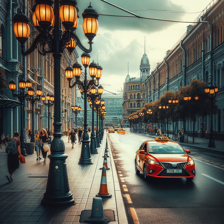
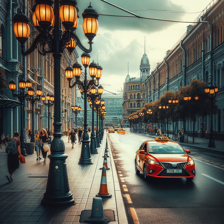
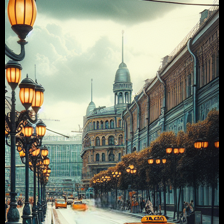
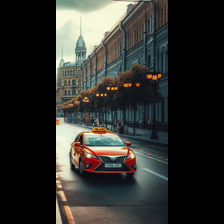
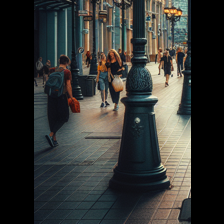
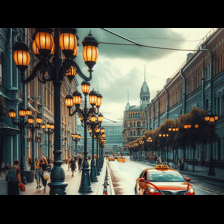
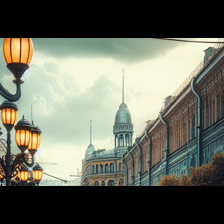
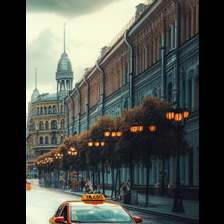
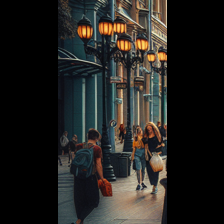
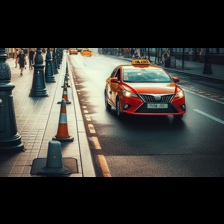
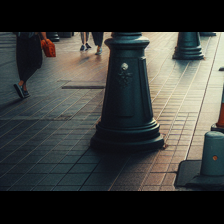
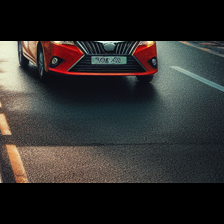
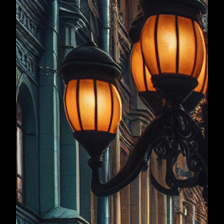
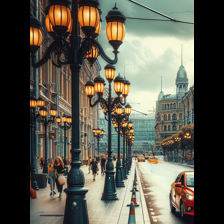
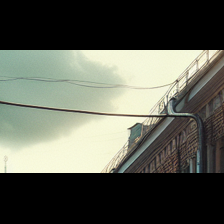
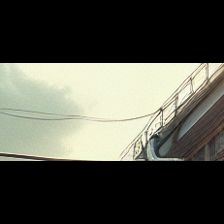
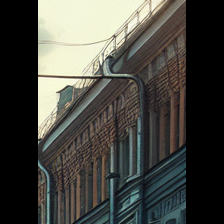
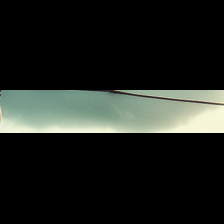
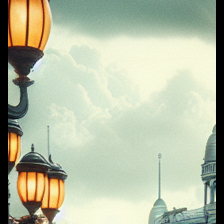
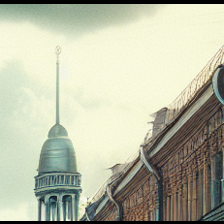
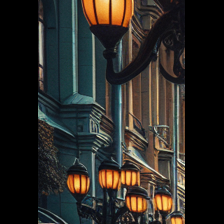
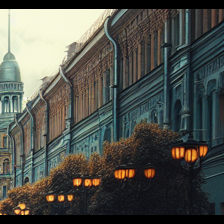
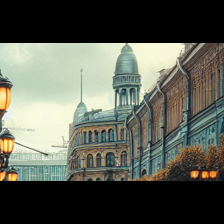
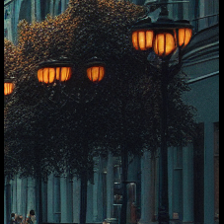
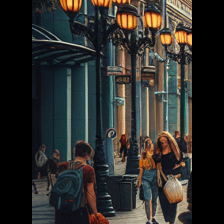
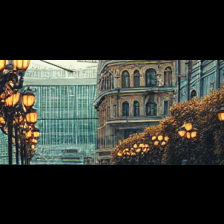
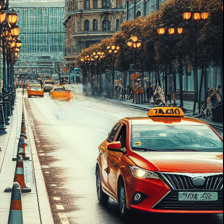
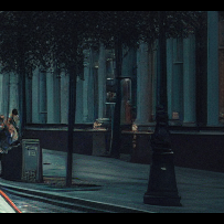
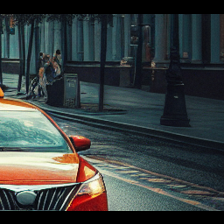
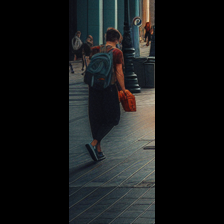
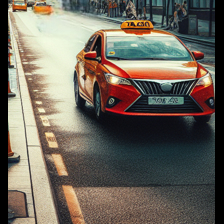
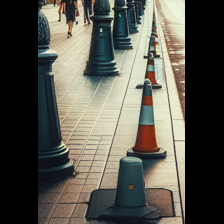
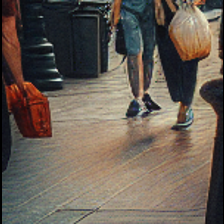
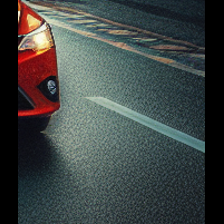
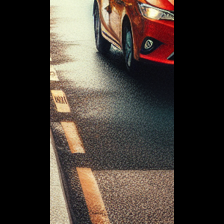
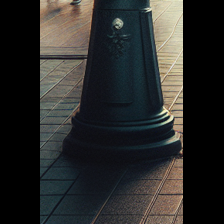
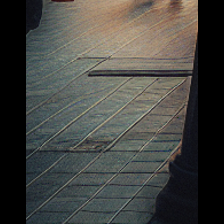
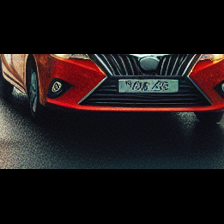
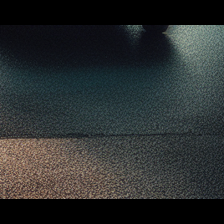
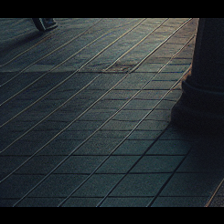
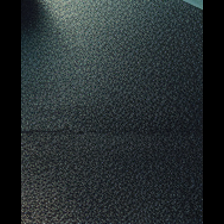
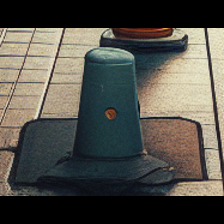
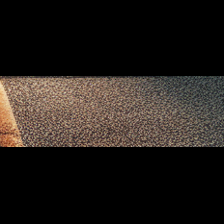


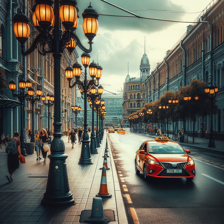
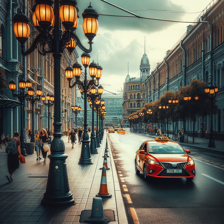
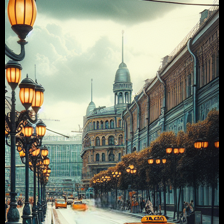
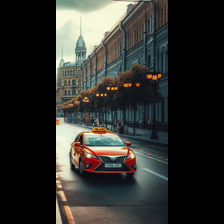
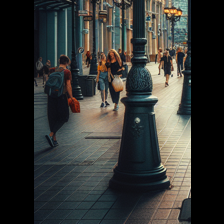
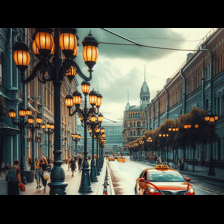
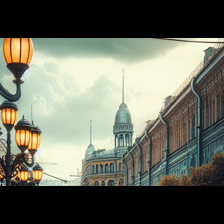
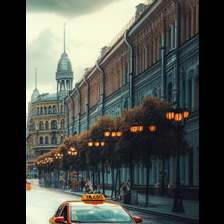
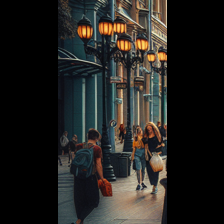
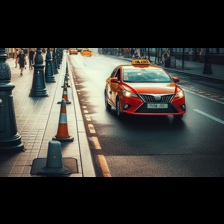
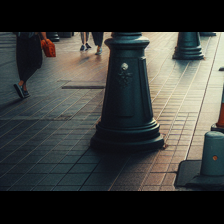
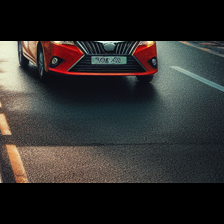
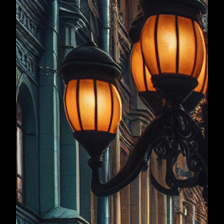
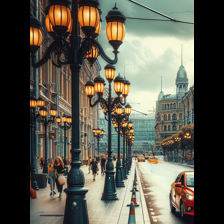
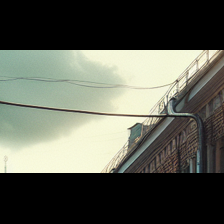
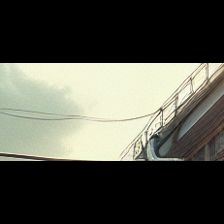
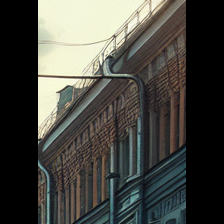
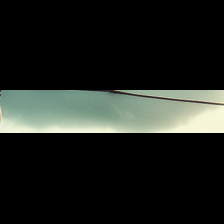
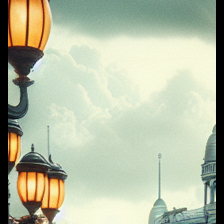
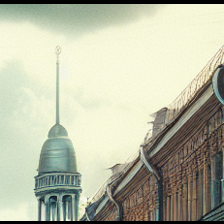
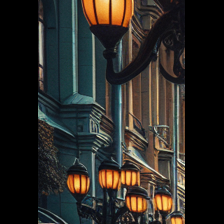
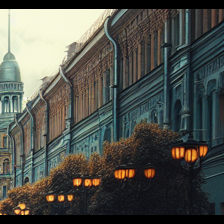
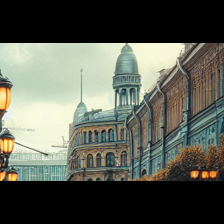
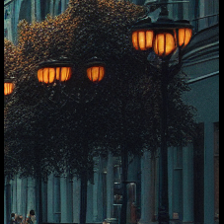
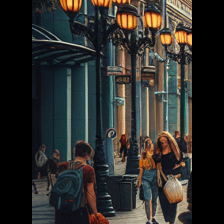
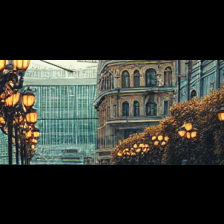
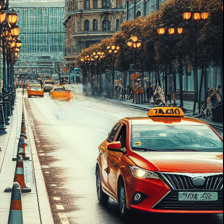
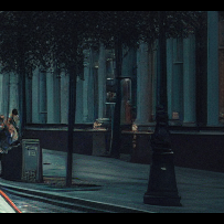
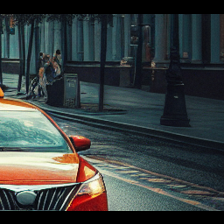
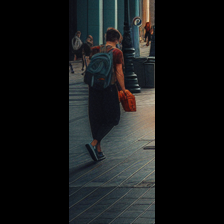
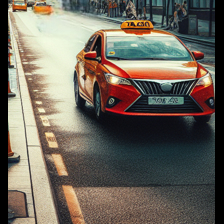
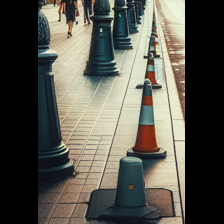
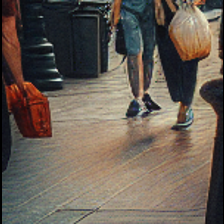
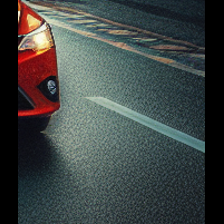
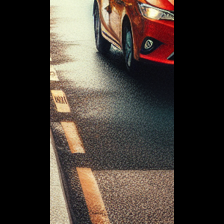
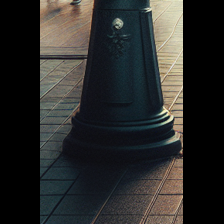
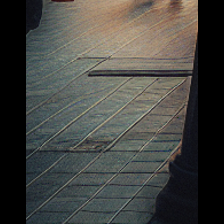
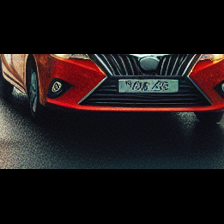
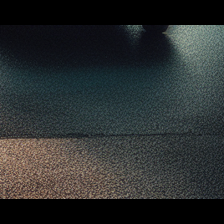
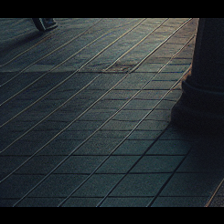
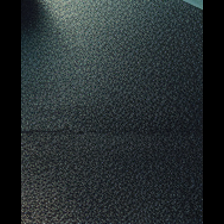
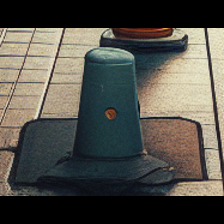
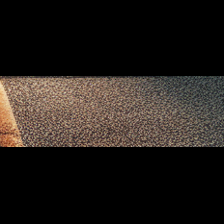

In [45]:
import matplotlib.pyplot as plt
import cv2
import PIL
import ipyplot

image_id = 1

# print(len(masks), len(new_img_file_name_ls), image_id)

# first_mask = masks[0][0]
# print(first_mask)

# print(len(first_mask))

# first_img = new_raw_img_ls[image_id]

first_img = Image.open(new_img_file_name_ls[image_id]).convert("RGB")

first_bbox_ls = bboxes[image_id]

# print(len(bboxes[image_id]))

# print(first_bbox_ls)

masked_image_ls = []

for idx in range(len(first_bbox_ls)):
    first_bbox = first_bbox_ls[idx]
    print(first_bbox)
    masked_image = np.copy(first_img)
    # # print(masked_image.shape)
    # masked_image[first_mask != (idx + 1)] = 255 # Set pixels outside the mask to 0
    curr_patch = PIL.Image.new('RGB', first_img.size)
    curr_patch.paste(first_img.copy().crop(first_bbox), box=first_bbox)
    masked_image = PIL.ImageOps.pad(curr_patch.crop(first_bbox), (224, 224))
    print(masked_image)
    # masked_image.save(f"crepe_data/partitioned/example_{idx}.jpg")
    # plt.savefig(f"crepe_data/partitioned/example_{idx}.jpg", bbox_inches='tight', pad_inches=0)
    masked_image_ls.append(masked_image)


ipyplot.plot_images(masked_image_ls, max_images=len(first_bbox_ls))   


# masked_image = cv2.rectangle(Image.fromarray(masked_image), (first_bbox[0], first_bbox[1]), (first_bbox[2], first_bbox[3]), (255, 0, 0), 2)

# Display the masked part of the image
# plt.imshow(masked_image)
# plt.axis('off')
# plt.show()

# print(np.unique(first_mask))

In [7]:
first_bbox = first_bbox_ls[56]

os.makedirs("/data2/wuyinjun/selfdriving_exp/", exist_ok=True)

curr_patch = PIL.Image.new('RGB', first_img.size)
curr_patch.paste(first_img.copy().crop(first_bbox), box=first_bbox)
masked_image = PIL.ImageOps.pad(curr_patch.crop(first_bbox), (224, 224))
print(masked_image)
masked_image.save(f"/data2/wuyinjun/selfdriving_exp/black_car.jpg")


<PIL.Image.Image image mode=RGB size=224x224 at 0x7FAB9A3CD340>


In [46]:
if image_id == 1:
    first_bbox = first_bbox_ls[38]

    curr_patch = PIL.Image.new('RGB', first_img.size)
    curr_patch.paste(first_img.copy().crop(first_bbox), box=first_bbox)
    masked_image = PIL.ImageOps.pad(curr_patch.crop(first_bbox), (224, 224))
    print(masked_image)
    masked_image.save(f"/data2/wuyinjun/selfdriving_exp/fake_black_car.jpg")

<PIL.Image.Image image mode=RGB size=224x224 at 0x7FAB9A4AC370>


In [8]:
first_bbox = first_bbox_ls[10]

curr_patch = PIL.Image.new('RGB', first_img.size)
curr_patch.paste(first_img.copy().crop(first_bbox), box=first_bbox)
masked_image = PIL.ImageOps.pad(curr_patch.crop(first_bbox), (224, 224))
print(masked_image)
masked_image.save(f"/data2/wuyinjun/selfdriving_exp/taxi.jpg")

<PIL.Image.Image image mode=RGB size=224x224 at 0x7FAEDC314FA0>


In [9]:
first_bbox = first_bbox_ls[52]

curr_patch = PIL.Image.new('RGB', first_img.size)
curr_patch.paste(first_img.copy().crop(first_bbox), box=first_bbox)
masked_image = PIL.ImageOps.pad(curr_patch.crop(first_bbox), (224, 224))
print(masked_image)
masked_image.save(f"/data2/wuyinjun/selfdriving_exp/people_1.jpg")

<PIL.Image.Image image mode=RGB size=224x224 at 0x7FAB9A4209A0>


In [10]:
first_bbox = first_bbox_ls[52]

curr_patch = PIL.Image.new('RGB', first_img.size)
curr_patch.paste(first_img.copy().crop(first_bbox), box=first_bbox)
masked_image = PIL.ImageOps.pad(curr_patch.crop(first_bbox), (224, 224))
print(masked_image)
masked_image.save(f"/data2/wuyinjun/selfdriving_exp/people_2.jpg")

<PIL.Image.Image image mode=RGB size=224x224 at 0x7FAB9A420F40>


In [139]:
# query="black SUV on the road, people on the sidewalk"
query="black SUV on the road. Poles on the road"


inputs = text_processor(query)
inputs = {key: val.to(device) for key, val in inputs.items()}
whole_text_features = model.get_text_features(**inputs)
print(whole_text_features.shape)

torch.Size([1, 768])


In [140]:
sim0 = torch.nn.functional.cosine_similarity(whole_text_features.cpu().view(1,-1), img_emb[0].cpu().view(1,-1))
print(sim0)

sim0_2 = torch.nn.functional.cosine_similarity(whole_text_features.cpu().view(1,-1), img_emb[1].cpu().view(1,-1))
print(sim0_2)

sim0_3 = torch.nn.functional.cosine_similarity(whole_text_features.cpu().view(1,-1), img_emb[2].cpu().view(1,-1))
print(sim0_3)


tensor([0.2034], grad_fn=<SumBackward1>)
tensor([0.2197], grad_fn=<SumBackward1>)
tensor([0.1803], grad_fn=<SumBackward1>)


In [41]:
sim1 = torch.nn.functional.cosine_similarity(whole_text_features.cpu().view(1,-1), patch_emb_by_img_ls[0].cpu())
print(sim1)
print(sim1.max())
print(sim1.argmax())


sim2 = torch.nn.functional.cosine_similarity(whole_text_features.cpu().view(1,-1), patch_emb_by_img_ls[1].cpu())
print(sim2)
print(sim2.max())
print(sim2.argmax())

tensor([0.2127, 0.2320, 0.2247, 0.1883, 0.1679, 0.2127, 0.2446, 0.2117, 0.1959,
        0.2591, 0.1606, 0.1801, 0.1786, 0.1761, 0.1488, 0.1790, 0.2306, 0.1781,
        0.1864, 0.2484, 0.2291, 0.1806, 0.1554, 0.1700, 0.1726, 0.1610, 0.1552,
        0.1521, 0.1651, 0.1375, 0.1487, 0.1424, 0.1467, 0.1756, 0.1899, 0.1707,
        0.1678, 0.2139, 0.1984, 0.1640, 0.1839, 0.1679, 0.1576, 0.1979, 0.1619,
        0.1854, 0.1901, 0.2046, 0.2457, 0.2484, 0.1749, 0.1545, 0.1919, 0.1425,
        0.1928, 0.1937, 0.2725, 0.1987, 0.2153, 0.1961, 0.1907, 0.2135, 0.1921,
        0.2066, 0.2208, 0.1989, 0.2147, 0.2246, 0.2176, 0.2153, 0.2127],
       grad_fn=<SumBackward1>)
tensor(0.2725, grad_fn=<MaxBackward1>)
tensor(56)
tensor([0.2208, 0.2208, 0.1612, 0.1984, 0.1592, 0.1950, 0.1376, 0.1763, 0.1505,
        0.1502, 0.1718, 0.2063, 0.1541, 0.1779, 0.1477, 0.1592, 0.1465, 0.1606,
        0.1282, 0.1630, 0.1787, 0.1445, 0.1414, 0.1828, 0.1547, 0.1546, 0.1916,
        0.2063, 0.1794, 0.1553, 0.1524, 0.1629

In [13]:
query1="taxi parking on the street"


inputs = text_processor(query1)
inputs = {key: val.to(device) for key, val in inputs.items()}
text_features1 = model.get_text_features(**inputs)
print(text_features1.shape)

torch.Size([1, 768])


In [14]:
sim1 = torch.nn.functional.cosine_similarity(text_features1.cpu().view(1,-1), patch_emb_by_img_ls[0][10].cpu().view(1,-1))
print(sim1)

sim2 = torch.nn.functional.cosine_similarity(text_features1.cpu().view(1,-1), img_emb[0].cpu().view(1,-1))
print(sim2)

tensor([0.2542], grad_fn=<SumBackward1>)
tensor([0.2178], grad_fn=<SumBackward1>)


In [15]:
query2="black car driving on the road"


inputs = text_processor(query2)
inputs = {key: val.to(device) for key, val in inputs.items()}
text_features2 = model.get_text_features(**inputs)
print(text_features2.shape)

torch.Size([1, 768])


In [16]:
sim1 = torch.nn.functional.cosine_similarity(text_features2.cpu().view(1,-1), patch_emb_by_img_ls[0][56].cpu().view(1,-1))
print(sim1)

sim2 = torch.nn.functional.cosine_similarity(text_features2.cpu().view(1,-1), img_emb[0].cpu().view(1,-1))
print(sim2)

tensor([0.2457], grad_fn=<SumBackward1>)
tensor([0.2110], grad_fn=<SumBackward1>)


In [17]:
query3="people cross the streets"


inputs = text_processor(query3)
inputs = {key: val.to(device) for key, val in inputs.items()}
text_features3 = model.get_text_features(**inputs)
print(text_features3.shape)

torch.Size([1, 768])


In [18]:
sim1 = torch.nn.functional.cosine_similarity(text_features3.cpu().view(1,-1), patch_emb_by_img_ls[0].cpu())
print(sim1)
print(sim1.argmax())
print(sim1.max())

sim2 = torch.nn.functional.cosine_similarity(text_features3.cpu().view(1,-1), patch_emb_by_img_ls[1].cpu())
print(sim2)

tensor([0.2012, 0.2340, 0.2340, 0.1994, 0.1840, 0.2012, 0.2357, 0.2243, 0.1855,
        0.2271, 0.1629, 0.1865, 0.1856, 0.1934, 0.1487, 0.2324, 0.2244, 0.2256,
        0.2085, 0.1930, 0.2015, 0.1876, 0.1680, 0.1950, 0.1718, 0.1626, 0.1647,
        0.1717, 0.1643, 0.1580, 0.1435, 0.1394, 0.1688, 0.1574, 0.2062, 0.1789,
        0.1648, 0.2137, 0.2071, 0.1614, 0.1743, 0.1631, 0.1691, 0.1999, 0.1694,
        0.1859, 0.1621, 0.1913, 0.2054, 0.2190, 0.1675, 0.2342, 0.2329, 0.2096,
        0.1596, 0.1741, 0.1871, 0.2167, 0.2141, 0.1496, 0.1540, 0.1484, 0.2219,
        0.1998, 0.1634, 0.1596, 0.1886, 0.1966, 0.1835, 0.1997, 0.2012],
       grad_fn=<SumBackward1>)
tensor(6)
tensor(0.2357, grad_fn=<MaxBackward1>)
tensor([0.2156, 0.2156, 0.1840, 0.1992, 0.2230, 0.2078, 0.1936, 0.1963, 0.1895,
        0.2442, 0.1517, 0.2346, 0.1675, 0.1989, 0.2139, 0.1802, 0.1727, 0.1921,
        0.1493, 0.1753, 0.1718, 0.2075, 0.2012, 0.2006, 0.2137, 0.2434, 0.2284,
        0.1962, 0.1886, 0.2200, 0.1822, 0.2092,

In [ ]:
import copy
from PIL import Image, ImageDraw
box_width=3

image_path = "/data2/wuyinjun/selfdriving.jpg"
# image_path="/data2/wuyinjun/flickr/flickr30k-images/1000366164.jpg"
image = Image.open(image_path)
draw = ImageDraw.Draw(image)
# exp_bbox = copy.copy(first_bbox_ls[11])
# exp_bbox[0] = exp_bbox[0] + 50
# print(exp_bbox)
# print(first_bbox_ls[11])
draw.rectangle(first_bbox_ls[56], outline="red", width=box_width)
# bounding_boxes = [first_bbox_ls[idx] for idx in bbox_ids]
# # Draw the bounding boxes
# for box in bounding_boxes:
#     print(box)
#     draw_dotted_rectangle(draw, box)
    # draw.rectangle(box, outline=box_color, width=box_width)

# draw.rectangle(first_bbox_ls[4], outline="red", width=box_width)    
# draw.rectangle(first_bbox_ls[56], outline="green", width=box_width)
image.save("/data2/wuyinjun/selfdriving_exp/selfdriving_with_bbox.jpg")
image.show()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Error: no "view" mailcap rules found for type "image/png"


In [51]:
if image_id==1:
    import copy
    from PIL import Image, ImageDraw
    box_width=10

    image_path = "/data2/wuyinjun/selfdriving2_1.png"
    # image_path="/data2/wuyinjun/flickr/flickr30k-images/1000366164.jpg"
    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)
    # exp_bbox = copy.copy(first_bbox_ls[11])
    # exp_bbox[0] = exp_bbox[0] + 50
    # print(exp_bbox)
    # print(first_bbox_ls[11])
    draw.rectangle(first_bbox_ls[38], outline="red", width=box_width)
    # bounding_boxes = [first_bbox_ls[idx] for idx in bbox_ids]
    # # Draw the bounding boxes
    # for box in bounding_boxes:
    #     print(box)
    #     draw_dotted_rectangle(draw, box)
        # draw.rectangle(box, outline=box_color, width=box_width)

    # draw.rectangle(first_bbox_ls[4], outline="red", width=box_width)    
    # draw.rectangle(first_bbox_ls[56], outline="green", width=box_width)
    image.save("/data2/wuyinjun/selfdriving_exp/selfdriving_with_bbox2.jpg")
    image.show()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Error: no "view" mailcap rules found for type "image/png"
